# Multiscale Markov State Models Example

In this tutorial, we will use **mMSM-Explore** to map a toy 1D energy landscape and build a **Multiscale Markov State Model (mMSM)** for it. We will then show an example of running the algorithm on an alanine dipeptide simulation.

### Imports:

In [189]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from scipy.misc import derivative
from mmsm.self_expanding_mmsm import SelfExpandingMultiscaleMSM
from mmsm.mmsm_config import mMSMConfig
from mmsm.mmsm_base.base_discretizer import BaseDiscretizer
from mmsm.mmsm_base.base_trajectory_sampler import BaseTrajectorySampler

# Filter some warnings so output is clearer
import warnings
from msmtools.util.exceptions import ImaginaryEigenValueWarning
warnings.filterwarnings("ignore", category=ImaginaryEigenValueWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Toy 1D energy landscape

We shall map the following 1D energy landscape:

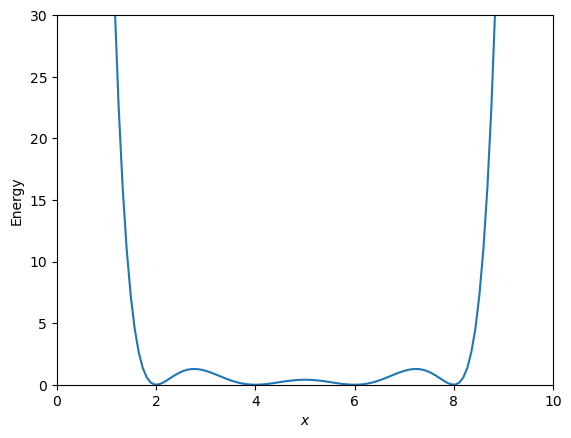

In [190]:
f = lambda x: 0.005 * (x - 2) ** 2 * (x - 4) ** 2 * (x - 6) ** 2 * (x - 8) ** 2
dfdx = lambda x: ((x - 8) * (x - 6) * (x - 4) * (x - 2) * (x ** 3 - 15 * x ** 2 + 70 * x - 100)) / 25

# fig, ax = plt.subplots(figsize=(12, 5))
plt.ylim(0, 30)
plt.xlim(0,10)
plt.xlabel("$x$")
plt.ylabel("Energy")
plt.plot(np.linspace(1, 9, 100), [f(x) for x in np.linspace(1, 9, 100)])
plt.show()

This energy function is similar to the one used for the two-sphere system in the paper. Here, the simulation is performed entirely in one dimension by simulating a random walk over the energy landscape. By contrast, in the paper, the simulation was carried out in six dimensions, with the energy function applied to the mutual distance between the spheres.

### Implemenating the simulator and discretizer

We first need to define a *simulator* and a *discretizer*.

Our simulator will simulate a Brownian dynamics trajectory along the energy landscape and generate a series of consecutive configurations, given some initial configuration.

The discretizer will take the series of system configurations in the $x$ space, and convert it to a series of discrete states. In this example, we divide the $x$ space into bins of equal length; each bin is assigned a unique integer index representing a discrete state.

In [191]:
class ToyTrajectorySampler(BaseTrajectorySampler):
    def __init__(self, f, dfdx, tau_0, init_state):
        self.f = f 
        self.dfdx = dfdx
        self.tau_0 = tau_0
        self.init_state = init_state
    
    @property
    def timestep_size(self):
        return self.tau_0

    def sample_from_states(self, states, sample_len, n_samples, sample_interval=1):
        trajs = []
        for s in states:
            for i in range(n_samples):
                x_cur = s
                temp_traj = [x_cur]
                for j in range(sample_len-1):
                    for step in range(sample_interval):
                        x_cur = self._step(x_cur)
                    temp_traj.append(x_cur)
                trajs.append(np.array(temp_traj))
        return trajs

    def get_initial_sample(self, sample_len, n_samples, sample_interval=1):
        return self.sample_from_states([self.init_state], sample_len, n_samples, sample_interval)

    def _step(self, x):
        return x - self.tau_0 * derivative(self.f, x, dx=1e-6) + np.sqrt(0.5 * self.tau_0) * np.random.normal(0, 1)


class ToyDiscretizer(BaseDiscretizer):
    def __init__(self, left, right, n_bins, representative_sample_size=10):
        super().__init__(representative_sample_size)
        self.left = left
        self.right = right
        self.n_bins = n_bins
        self.intervals = np.linspace(left, right, num=n_bins+1)

    @property
    def n_states(self):
        return self.n_bins

    def _coarse_grain_states(self, data : np.ndarray):
        return np.digitize(data, self.intervals) - 1

    def get_centers_by_ids(self, cluster_ids):
        return [(self.intervals[c] + self.intervals[c + 1]) / 2 for c in cluster_ids]

    def sample_from(self, cluster_id):
        return self.get_centers_by_ids([cluster_id])[0]

# Example
sampler_ex = ToyTrajectorySampler(f, dfdx, tau_0=0.01, init_state=2)
discretizer_ex = ToyDiscretizer(left=1, right=9, n_bins=200)
traj_ex = sampler_ex.sample_from_states([2], 10, 1)  # sample 1 trajectory of 10 states, starting at x=2
dtraj_ex = discretizer_ex.get_coarse_grained_states(traj_ex[0])  # get_coarse_grained_states() is implemented in BaseDiscretizer
print(traj_ex)
print(dtraj_ex)

[array([2.        , 2.02340174, 1.97429652, 2.01930502, 2.10738232,
       2.17593513, 2.25257825, 2.44919099, 2.45046768, 2.49340575])]
[25 25 24 25 27 29 31 36 36 37]


For visualization, we'll also define two helper functions. This is **not** required for running the algorithm.

In [192]:
def mmsm_to_nx(mmsm: SelfExpandingMultiscaleMSM):
    G = nx.DiGraph()
    G.add_nodes_from([v for h in range(mmsm.tree.height + 1) for v in mmsm.tree.get_level(h)])
    for h in range(mmsm.tree.height + 1):
        lvl_sd = mmsm.tree.get_level_stationary_distribution(h)
        for v_src in mmsm.tree.get_level(h):  # iterate over vertices
            t_out_ids, t_out = mmsm.tree.get_external_T(v_src)  # get the outgoing transitions of the vertex
            G.nodes[v_src]['p'] = lvl_sd[v_src]
            G.nodes[v_src]['h'] = h
            for dst_i, v_dst in enumerate(t_out_ids):
                G.add_edge(v_src, v_dst, p=t_out[dst_i])
            G.add_edge(mmsm.tree.get_parent(v_src), v_src)  # add edge from parent to this vertex
    return G

def visualize(mmsm: SelfExpandingMultiscaleMSM):
    mmsm_nx = mmsm_to_nx(mmsm)
    pos = dict()
    Y_START = 7
    Y_SPACING = 1.5
    free_en = {ms: -np.log(v) * 0.593 for ms, v in mmsm.tree.get_full_stationary_distribution().items()}
    free_en_C = np.min(list(free_en.values()))
    for h in range(mmsm.tree.height + 1):
        for v in mmsm.tree.get_level(h):
            if h == 0:  # position microstates according to their energy value
                pos_x = mmsm.discretizer.get_centers_by_ids([v])[0]
                pos_y = 0.593 * -np.log(mmsm_nx.nodes[v]['p']) - free_en_C
            else:  # all other nodes built hierarchically over the microstates
                pos_x = np.mean([pos[child][0] for child in mmsm.tree.vertices[v].children])
                pos_y = Y_START + Y_SPACING*(h-1)
            pos[v] = (pos_x, pos_y)
    
    
    # Selects only horizontal edges (between levels)
    edge_filter_h = lambda e: mmsm_nx.nodes[e[0]]['h'] != mmsm_nx.nodes[e[1]]['h']

    # Selects edges on the same level, excluding self edges and edges among microstates.
    edge_filter_v = lambda e: e[0] != e[1] and mmsm_nx.nodes[e[0]]['h'] == mmsm_nx.nodes[e[1]]['h'] and mmsm_nx.nodes[e[0]]['h'] != 0

    node_sizes = [5 + 195 * mmsm_nx.nodes[v]['p']**0.99 for v in mmsm_nx.nodes]
    edge_sizes = [(0.1 + (3 * mmsm_nx.edges[e]['p']**0.5))*mmsm_nx.nodes[e[0]]['h'] for e in mmsm_nx.edges if edge_filter_v(e)]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.ylim(0, np.maximum(25, Y_START + Y_SPACING*h))
    plt.xlim(0,10)
    nx.draw_networkx_nodes(mmsm_nx, pos=pos, ax=ax, node_size=node_sizes)
    nx.draw_networkx_edges(mmsm_nx, 
                           edgelist=[e for e in mmsm_nx.edges if edge_filter_h(e)], 
                           pos=pos, ax=ax, node_size=node_sizes, arrows=False, alpha=0.5, width=0.5, edge_color='gray')
    nx.draw_networkx_edges(mmsm_nx, 
                           edgelist=[e for e in mmsm_nx.edges if edge_filter_v(e)], 
                           pos=pos, ax=ax, node_size=node_sizes, width=edge_sizes, connectionstyle="arc3,rad=0.07")
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_axis_on()
    plt.xlabel("$x$")
    plt.ylabel("Energy")
    plt.show()

### Running the algorithm and visualizing the structure

We set the simulation to begin at $x=2$, and simulate at steps of $\tau_0=0.01$. The discretizer will divide the $[1,9]$ interval into 100 bins of equal lengths.

Calling `SelfExpandingMultiscaleMSM.expand` runs the mMSM-explore loop for a specified number of iterations. Each iteration (or “batch”) consists of `n_trajectories` trajectories of `trajectory_len` configurations.

In [193]:
sampler = ToyTrajectorySampler(f, dfdx, tau_0=0.01, init_state=2)
discretizer = ToyDiscretizer(left=1, right=9, n_bins=200)
# In each batch, simulate 2 trajectories of 1000 configurations. Starting configuration sampled using a
# 50/50 mixture of equilibrium and exploration-biased distributions (favoring underexplored regions, see paper)
cnfg = mMSMConfig(n_trajectories=2, trajectory_len=1000,
                  sampling_heuristics=['equilibrium', 'exploration'],
                  sampling_heuristic_weights=[0.5, 0.5])
toy_mmsm = SelfExpandingMultiscaleMSM(sampler, discretizer, config=cnfg)
toy_mmsm.expand(max_batches=1)

Visualize the intermediate structure:

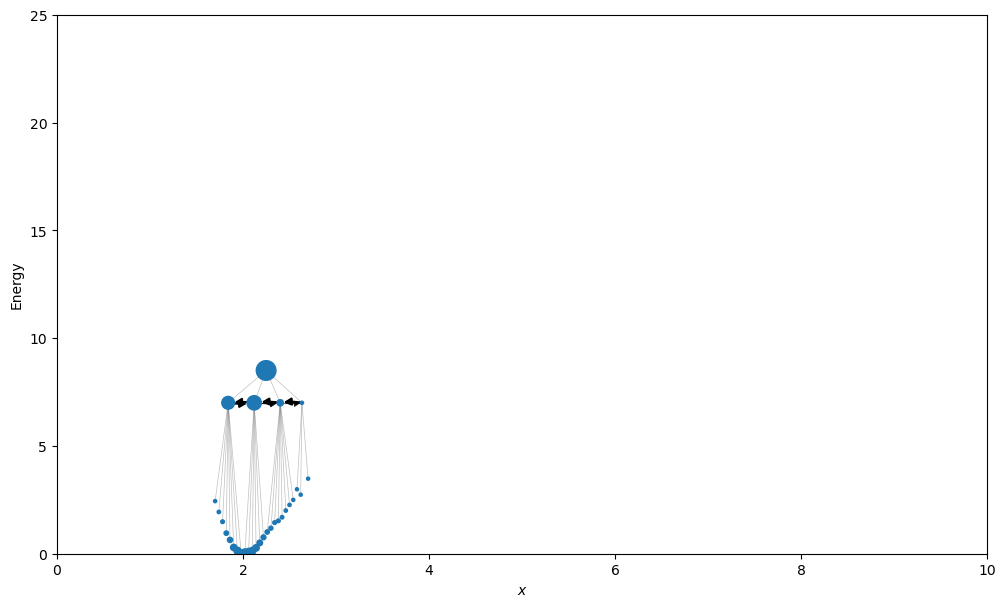

In [12]:
visualize(toy_mmsm)

This visualization displays all levels of the hiearachical structure, rom the microstates at the bottom to the root macrostate at the top. Microstates are plotted according to their energy values (estimated via Boltzmann inversion). At each higher level, macrostates form progressively coarser partitions of those microstates, culminating in a single root macrostate spanning the portion of $x$-space explored so far. Node sizes and edge widths indicate estimated stationary and transition probabilities, respectively.

After this short expansion, we likely observe that the leftmost basin is substantially explored, and that the model has begun crossing the energy barrier (results may vary due to the stochastic nature of the simulation). At lower levels of the hierarchy, macrostates represent small diffusion-limited regions, while higher levels group together entire basins separated by larger energy barriers.

To continue exploration, we can run several more batches and visualize again:

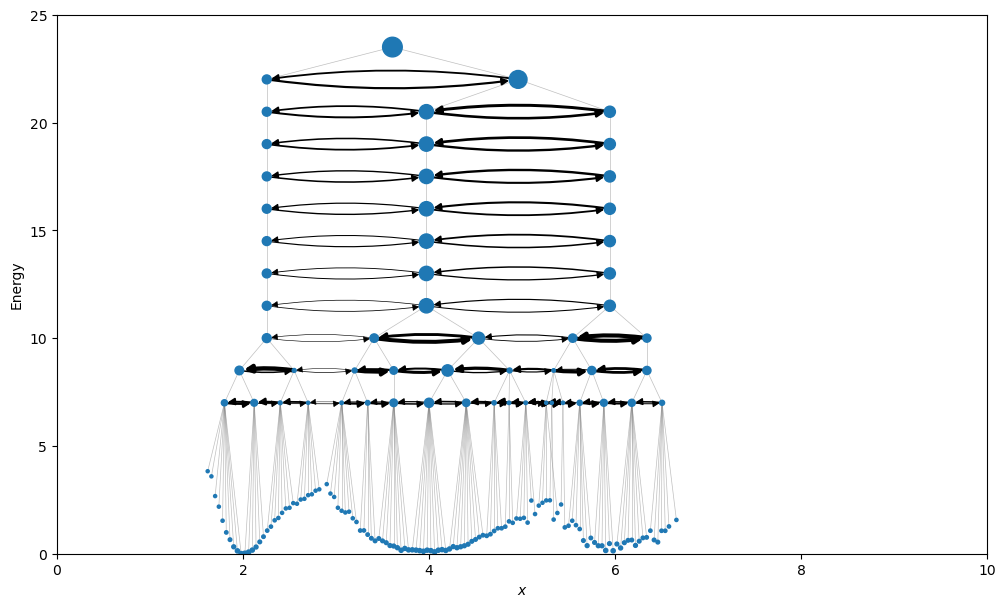

In [13]:
toy_mmsm.expand(max_batches=5)
visualize(toy_mmsm)

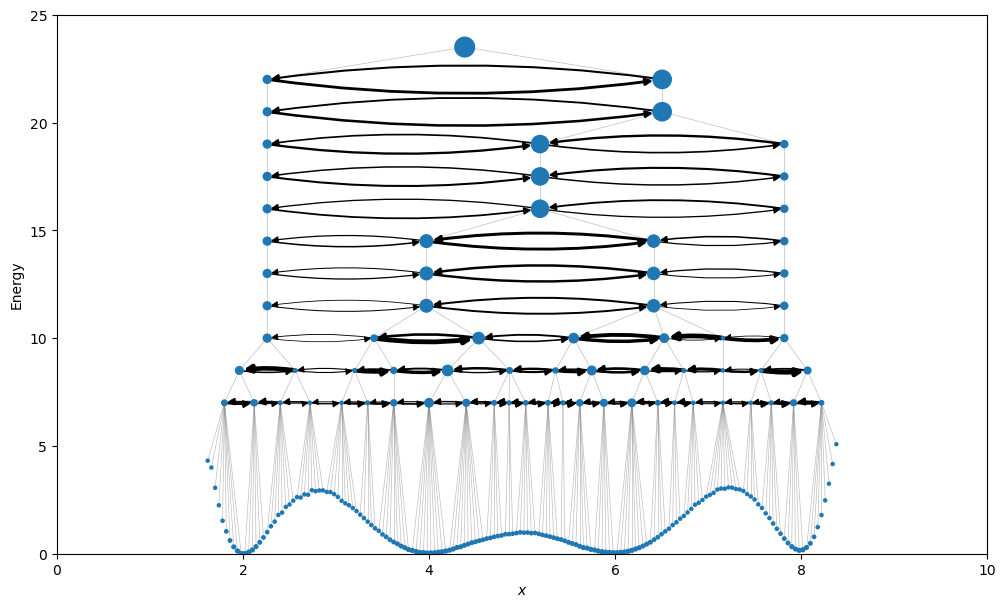

In [14]:
toy_mmsm.expand(max_batches=500)
visualize(toy_mmsm)

The final structure should cover the entire feasible configuration space. Each of the four energy basins should appear as a distinct macrostate at some hierarchy level, and the two center basins (separated by a smaller barrier) may merge into one macrostate at a higher level, which reflects a larger timescale.

---

### Further analysis

We can also run a naive simulation of the system and compare its empirical distribution with the microstate distribution from the mMSM:

In [ ]:
# Naive sim
n_bins = 200
naive_sampler = ToyTrajectorySampler(f, dfdx, tau_0=0.01, init_state=2)
hist = np.zeros(n_bins)
bin_edges = np.linspace(1, 9, n_bins+1)
last_config = 2
for i in range(10000):
    traj = naive_sampler.sample_from_states([last_config], 1000, 1)
    last_config = traj[0][-1]
    hist += np.histogram(traj, bins=n_bins, range=(1, 9))[0]

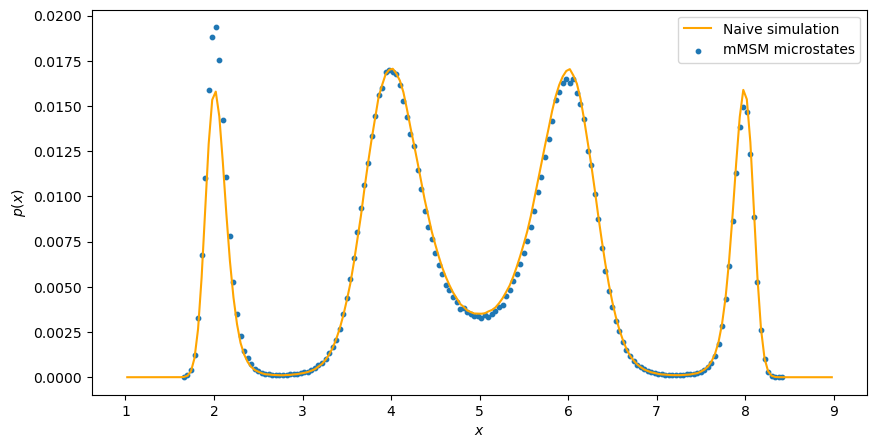

In [10]:
# Get the mMSM microstate distribution
sd = toy_mmsm.tree.get_level_stationary_distribution(0)
mmsm_sd = {toy_mmsm.discretizer.get_centers_by_ids([bin_id])[0]: p for bin_id, p in sd.items()}

# Plot
plt.figure(figsize=(10,5))
plt.plot([(bin_edges[b] + bin_edges[b + 1]) / 2 for b in range(n_bins)], hist / hist.sum(), label="Naive simulation", c="orange")
plt.scatter(list(mmsm_sd.keys()), list(mmsm_sd.values()), s=10, label="mMSM microstates")
plt.legend(loc='upper right')
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.show()

## Alanine dipeptide

In this section, we will run **mMSM-explore** on a Langevin dynamics simulation of alanine dipeptide.

In [168]:
from implementations.alaninedp.alaninedp_sim import DialanineOMMSampler
from implementations.alaninedp.alaninedp_discretizers import DialanineDiscretizerV

### Setup

As before, we begin by providing a sampler and a discretizer. We will use the same implementations utilized for the paper's results.

The *sampler* encapsulates an [OpenMM](https://openmm.org) molecular dynamics simulation of alanine dipeptide. In principle, it is identical to the one defined for the toy example: it generates trajectories of consecutive system configurations. In this case, each trajectory consists of configurations with shape `(2, 22, 3)`, representing the 3D coordinates and velocities of all 22 atoms.

The *discretizer* calculates the dihedral angles $\phi$ and $\psi$ for each configuration and assigns it a discrete microstate label using K-medoids clustering.

In [290]:
adp_sampler = DialanineOMMSampler(prmtop_path='./implementations/alaninedp/runfiles/diala.top', 
                                  dt_ps=0.002, temp0=400, return_vs=True, concurrent_sims=5)
adp_discretizer = DialanineDiscretizerV(cutoff=5)
adp_sampler.initial_state = np.load('./implementations/alaninedp/runfiles/minimized_initial_state.npy')

(Some optional code for fancy visualizations follows.)

In [291]:
from scipy.spatial import distance_matrix
import random
cmap = list(plt.get_cmap('tab20b').colors)[1:]
random.seed(7)
random.shuffle(cmap)
def visualize_2d(mmsm: SelfExpandingMultiscaleMSM, ax, level=0):
    bin_num = 30
    sd = mmsm.tree.get_level_stationary_distribution(0)
    centers = mmsm.discretizer.get_centers_by_ids(sd.keys())
    en = np.histogram2d(centers[:, 0], centers[:, 1], bins=(bin_num, bin_num), range=[[-180, 180], [-180, 180]],
                          weights=list(sd.values()))[0]
    mask = en > 0
    en[mask] = -np.log(en[mask]) * 0.593
    en[mask] -= np.min(en[mask])
    en[~mask] = np.nan
    cf=ax.contourf(np.linspace(-180,180, bin_num), np.linspace(-180,180, bin_num), en.T,
                 levels=100, cmap='RdYlBu_r')
    ax.set_xlabel("$\phi$", fontsize='large')
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xlim(-180, 180)
    ax.set_ylabel("$\psi$", fontsize='large')
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_ylim(-180, 180)
    cbar = ax.figure.colorbar(cf, ax=ax)
    cbar.set_label('Energy ($kT$)', size='large')

    mmsm_nx = nx.DiGraph()
    nx_pos = dict()
    nx_colors = dict()
    level_macrostates = mmsm.tree.get_level(level)
    mmsm_nx.add_nodes_from(level_macrostates)
    lvl_sd = mmsm.tree.get_level_stationary_distribution(level)

    
    
    for li, macrostate in enumerate(level_macrostates):
        
        color = cmap[li % len(cmap)]
        # color = plt.cm.tab20b(li/len(level_macrostates))
        # plot microstates as point clusters
        microstates = mmsm.tree.get_microstates(macrostate)
        microstates = mmsm.discretizer.get_centers_by_ids(microstates)
        ax.scatter(microstates[:, 0], microstates[:, 1],s=20, alpha=0.5, linewidths=0, 
                    color=color)

        # set stationary dist
        mmsm_nx.nodes[macrostate]['p'] = lvl_sd[macrostate]

        # add transitions
        for v_dst, prob in zip(*mmsm.tree.get_external_T(macrostate)):
            mmsm_nx.add_edge(macrostate, v_dst, p=prob)
            
        # set node positions
        dists = distance_matrix(microstates, microstates)
        dists = dists <= 20
        g = nx.from_numpy_array(dists)
        components = list(nx.connected_components(g))
        lrgst = components[np.argmax([len(cmp) for cmp in components])]
        pts = [microstates[p] for p in lrgst]
        rep = np.mean(pts, axis=0)
        nx_pos[macrostate] = tuple(rep)

        # etc
        nx_colors[macrostate] = color
    
    edge_filter = lambda e: e[0] != e[1]
    
    node_sizes = [20*level + 1000 * mmsm_nx.nodes[v]['p']**0.99 for v in mmsm_nx.nodes]
    
    edge_sizes = [(0.5*level + (0.2 * np.log(mmsm_nx.edges[e]['p']))) for e in mmsm_nx.edges if edge_filter(e)]
    
    nx.draw_networkx_nodes(mmsm_nx, pos=nx_pos, ax=ax, node_size=node_sizes, 
                           node_color=list(nx_colors.values()), edgecolors='black')
    nx.draw_networkx_edges(mmsm_nx, edgelist=[e for e in mmsm_nx.edges if edge_filter(e)],
                           pos=nx_pos, ax=ax, node_size=node_sizes, width=edge_sizes, connectionstyle="arc3,rad=0.07")

    
def plot_last_four_levels(mmsm: SelfExpandingMultiscaleMSM):
    mmsm_levels = [len(lvl) for lvl in mmsm.tree._levels.values()]
    shw = [mmsm_levels.index(h) for h in np.unique(mmsm_levels)[1:-1]]
    fig, axes = plt.subplots(2, 2, figsize=(11,8.5))
    for h, sp_ax in zip(shw, axes.flat):
        sp_ax.set_title(f"$M^{h+1}$")
        visualize_2d(adp_mmsm, sp_ax, h+1)
    fig.tight_layout()

### Running the algorithm

In [292]:
# Each batch simulates 5 trajectories, each consisting of 1000 consecutive configurations,
# sampled at a lag time of 10 * base_tau (i.e., every 10 integration steps). Note that the underlying 
# dynamics are still integrated using the base timestep (0.002 ps, here), and only every 10th 
# configuration is retained.
adp_cnfg = mMSMConfig(n_trajectories=5, trajectory_len=1000,
                  sampling_heuristics=['equilibrium', 'exploration'],
                  sampling_heuristic_weights=[0.5, 0.5], base_tau=10)
adp_mmsm = SelfExpandingMultiscaleMSM(adp_sampler, adp_discretizer, config=adp_cnfg)
adp_mmsm.expand(max_batches=10)

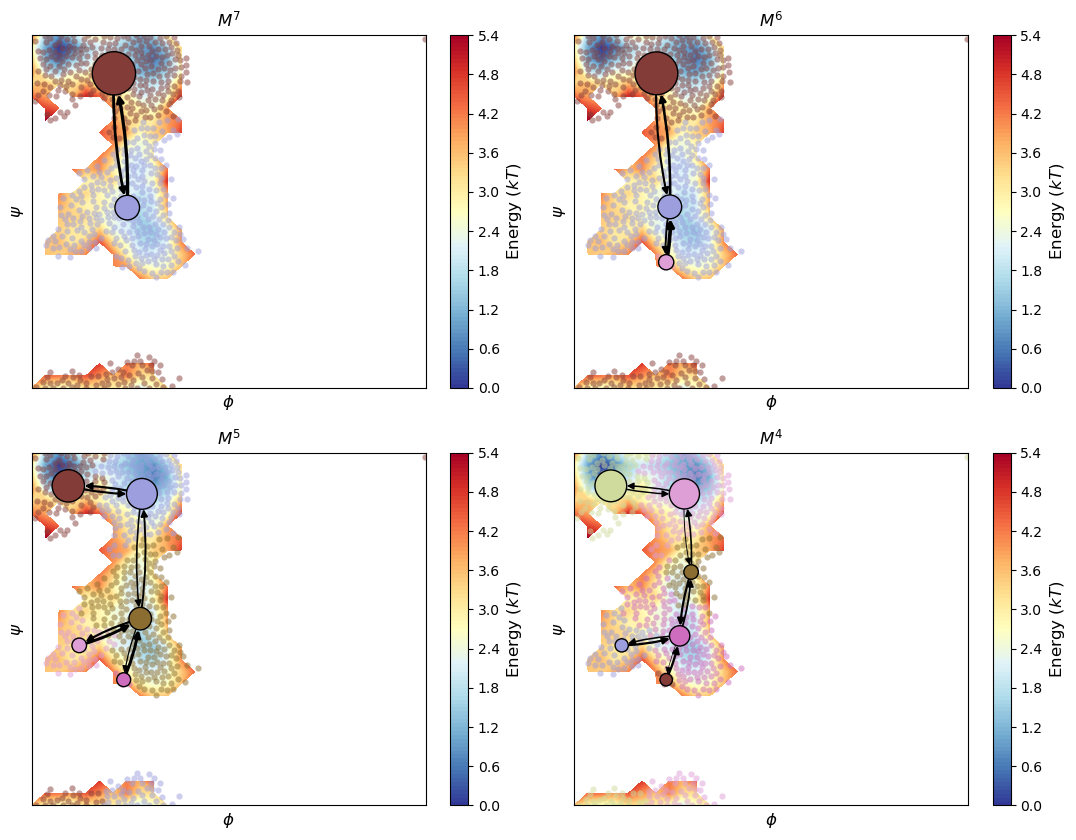

In [293]:
# Visulize the top *distinct* four levels (i.e., excluding levels whose macrostate partitions are identical
plot_last_four_levels(adp_mmsm)

In each figure, the microstates are scattered as trasnparent points over the energy landscape (as currently estimated). Their color indicates their assignment to a macrostate on the displayed level (some colors are duplicated).

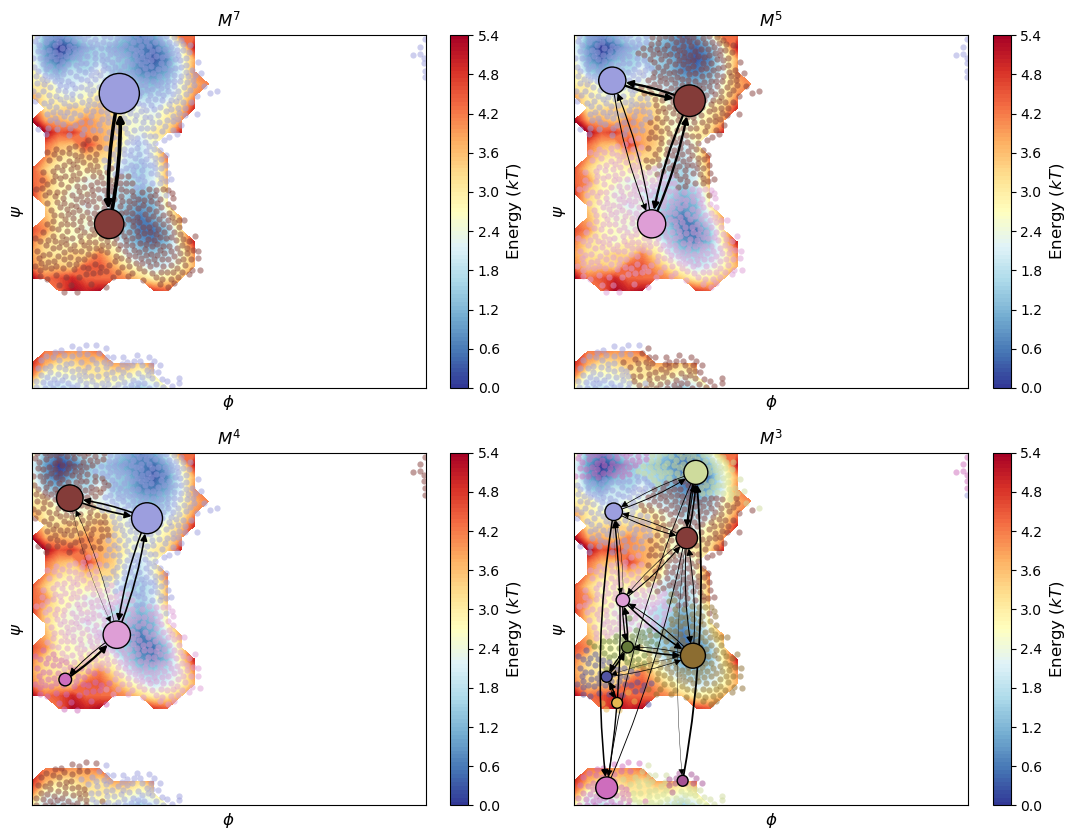

In [294]:
# Simulate some more
adp_mmsm.expand(max_batches=20)
plot_last_four_levels(adp_mmsm)

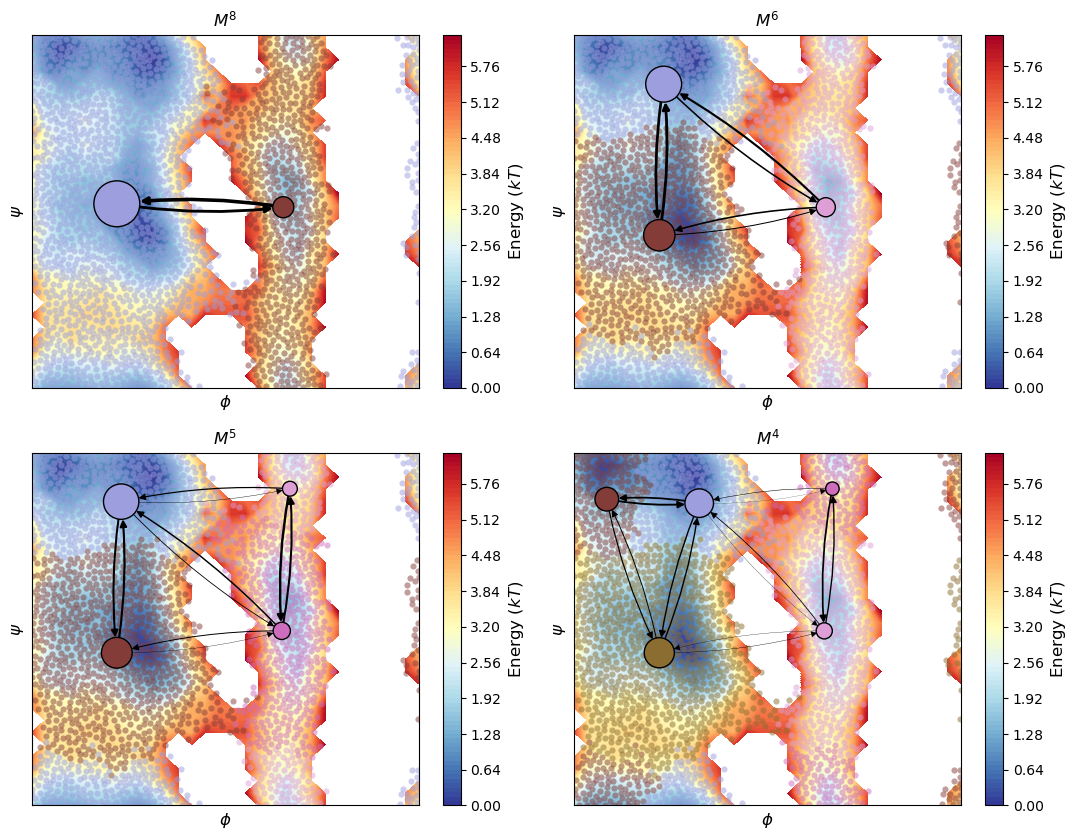

In [295]:
adp_mmsm.expand(max_batches=200)
plot_last_four_levels(adp_mmsm)
# Most of the energy landscape should be explored by this point